In [1]:
# Import packages
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# List files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# Import data
df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [4]:
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


### Data Cleaning

In [5]:
# Standardising Name column

# Rename Name column
df.rename(columns={"Name": "Name_Ori"}, inplace=True)

# Extract surname
df["Last_Name"] = df["Name_Ori"].apply(lambda x: x.split(",")[0].strip())

# Extract title
df["Title"] = df["Name_Ori"].apply(lambda x: x.split(",")[1].split(".")[0].strip())

# Extract first name
def extract_first_name(name):
    try:
        first_name_part = name.split(",")[1].split(".")[1].strip()
        first_name = first_name_part.split("(")[0].split('"')[0].strip()
        return first_name
    except:
        return None

df["First_Name"] = df["Name_Ori"].apply(extract_first_name)

# Extract additional info from Name_Ori for Name_Additional

def extract_name_additional(name):
    matches = re.findall(r'\(.*?\)|".*?"', name)
    if matches:
        return " ".join(matches).replace("(", "").replace(")", "").replace('"', "").strip()  # Clean formatting
    return None

df["Name_Additional"] = df["Name_Ori"].apply(extract_name_additional)


print(df[["Name_Ori", "Title", "First_Name", "Last_Name", "Name_Additional"]].head())

                                            Name_Ori Title     First_Name  \
0                            Braund, Mr. Owen Harris    Mr    Owen Harris   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   Mrs   John Bradley   
2                             Heikkinen, Miss. Laina  Miss          Laina   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   Mrs  Jacques Heath   
4                           Allen, Mr. William Henry    Mr  William Henry   

   Last_Name         Name_Additional  
0     Braund                    None  
1    Cumings  Florence Briggs Thayer  
2  Heikkinen                    None  
3   Futrelle           Lily May Peel  
4      Allen                    None  


In [6]:
# Clean Ticket Column

# Function to split ticket
def split_ticket(ticket):
    if pd.isna(ticket) or ticket.strip() == "":
        return "None", "Unknown"
    
    match = re.match(r"([a-zA-Z/. ]+)?(\d+)", ticket)
    if match:
        prefix = match.group(1).strip() if match.group(1) else "None"
        number = match.group(2) if match.group(2) else "Unknown"
    else:
        prefix, number = "None", "Unknown"
    
    return prefix, number

# Create new columns
df[["Ticket_Prefix", "Ticket_Number"]] = df["Ticket"].apply(lambda x: pd.Series(split_ticket(str(x))))

print(df[["Ticket", "Ticket_Prefix", "Ticket_Number"]].head(20))

              Ticket Ticket_Prefix Ticket_Number
0          A/5 21171            A/             5
1           PC 17599            PC         17599
2   STON/O2. 3101282        STON/O             2
3             113803          None        113803
4             373450          None        373450
5             330877          None        330877
6              17463          None         17463
7             349909          None        349909
8             347742          None        347742
9             237736          None        237736
10           PP 9549            PP          9549
11            113783          None        113783
12         A/5. 2151            A/             5
13            347082          None        347082
14            350406          None        350406
15            248706          None        248706
16            382652          None        382652
17            244373          None        244373
18            345763          None        345763
19              2649

In [7]:
# Create new column to group families / groups

# Count passengers sharing the same Last_Name and Ticket
df["Group_Size"] = df.groupby(["Last_Name", "Ticket"])["PassengerId"].transform("count")

# Define Family/Party Grouping logic
df["Family and Party Grouping"] = df.apply(
    lambda row: row["Last_Name"] if (row["SibSp"] > 0 or row["Parch"] > 0 or row["Group_Size"] > 1) else "Individual",
    axis=1
)

# Drop the temporary 'Group_Size' column
df.drop(columns=["Group_Size"], inplace=True)

# Verify results
print(df[["Last_Name", "SibSp", "Parch", "Ticket", "Family and Party Grouping"]].head(20))

        Last_Name  SibSp  Parch            Ticket Family and Party Grouping
0          Braund      1      0         A/5 21171                    Braund
1         Cumings      1      0          PC 17599                   Cumings
2       Heikkinen      0      0  STON/O2. 3101282                Individual
3        Futrelle      1      0            113803                  Futrelle
4           Allen      0      0            373450                Individual
5           Moran      0      0            330877                Individual
6        McCarthy      0      0             17463                Individual
7         Palsson      3      1            349909                   Palsson
8         Johnson      0      2            347742                   Johnson
9          Nasser      1      0            237736                    Nasser
10      Sandstrom      1      1           PP 9549                 Sandstrom
11        Bonnell      0      0            113783                Individual
12    Saunde

In [8]:
# Clean Age column

# Round age values
df["Age"] = df["Age"].apply(lambda x: 1 if pd.notnull(x) and x < 1 else round(x) if pd.notnull(x) else x)

# Calculate median Age for each Title group
title_medians = df.groupby("Title")["Age"].median()

# Fill missing ages using Title-based median
df["Age"] = df.apply(lambda row: title_medians[row["Title"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)

print(df["Age"].describe())

count    891.000000
mean      29.386644
std       13.261037
min        1.000000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64


In [9]:
# Define features to keep
selected_features = [
    "Pclass",
    "Sex",
    "Age",
    "Fare",
    "Title",
    "Family and Party Grouping",
    "Ticket_Prefix",
    "Embarked"
]

# Create new DataFrame with selected features
df_features = df[selected_features].copy()

print(df_features.head())

   Pclass     Sex   Age     Fare Title Family and Party Grouping  \
0       3    male  22.0   7.2500    Mr                    Braund   
1       1  female  38.0  71.2833   Mrs                   Cumings   
2       3  female  26.0   7.9250  Miss                Individual   
3       1  female  35.0  53.1000   Mrs                  Futrelle   
4       3    male  35.0   8.0500    Mr                Individual   

  Ticket_Prefix Embarked  
0            A/        S  
1            PC        C  
2        STON/O        S  
3          None        S  
4          None        S  


### Visualising Relationships

In [10]:
# Load Survived column separately
df_features["Survived"] = df["Survived"]

# Set style
sns.set_style("whitegrid")

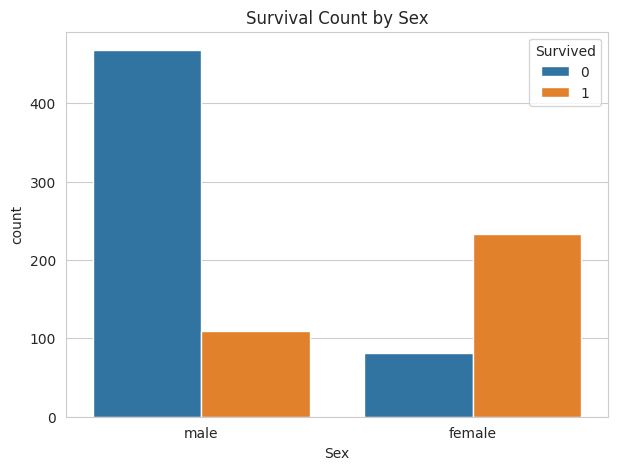

In [11]:
# Survival Rate by Sex
sns.set_style("whitegrid")
plt.figure(figsize=(7, 5))
sns.countplot(x="Sex", hue="Survived", data=df_features)
plt.title("Survival Count by Sex")
plt.show()

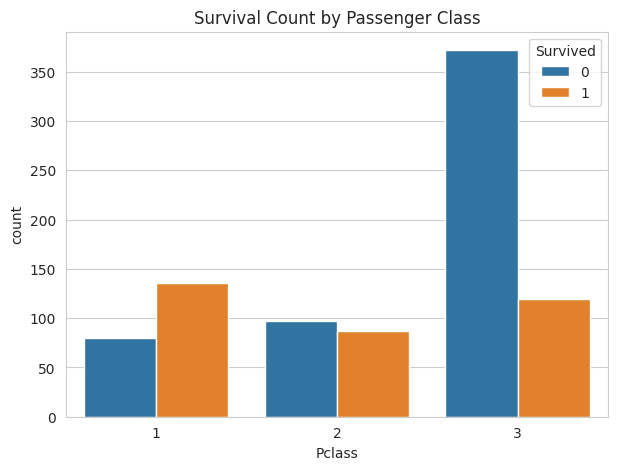

In [12]:
# Survival Rate by Pclass
plt.figure(figsize=(7, 5))
sns.countplot(x="Pclass", hue="Survived", data=df_features)
plt.title("Survival Count by Passenger Class")
plt.show()

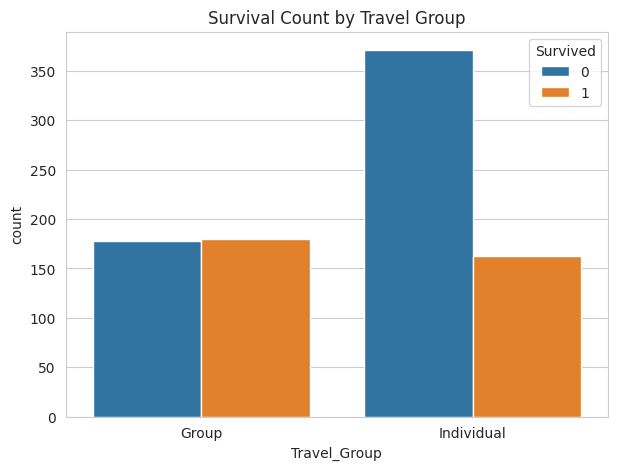

In [13]:
# Survival Rate by individual vs group travelers

# Create new column to group individuals vs groups
df_features["Travel_Group"] = df_features["Family and Party Grouping"].apply(lambda x: "Individual" if x == "Individual" else "Group")

# Survival Rate by Travel Group
plt.figure(figsize=(7, 5))
sns.countplot(x="Travel_Group", hue="Survived", data=df_features)
plt.title("Survival Count by Travel Group")
plt.show()

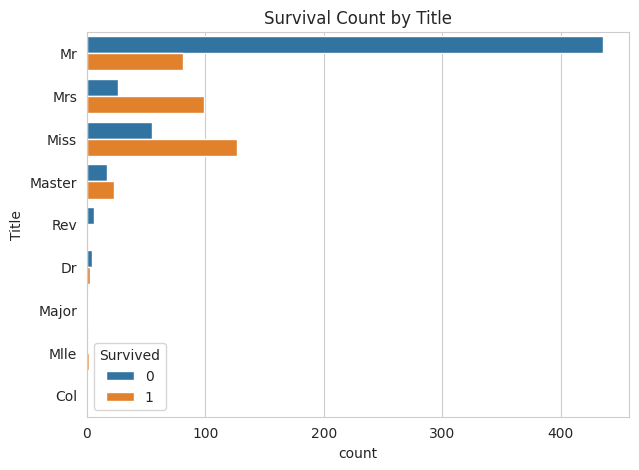

In [14]:
# Filter out rare titles (once or less)
title_counts = df_features["Title"].value_counts()
valid_titles = title_counts[title_counts > 1].index
df_filtered = df_features[df_features["Title"].isin(valid_titles)]

# Survival Rate by Title
plt.figure(figsize=(7, 5))
sns.countplot(y="Title", hue="Survived", data=df_filtered)
plt.title("Survival Count by Title")
plt.show()

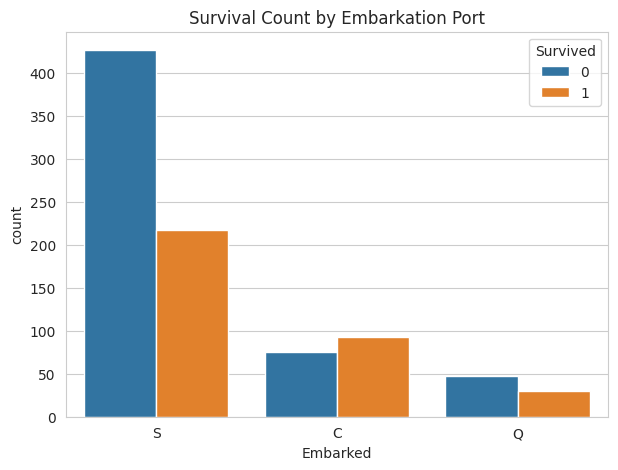

In [15]:
# Survival Rate by Embarked
plt.figure(figsize=(7, 5))
sns.countplot(x="Embarked", hue="Survived", data=df_features)
plt.title("Survival Count by Embarkation Port")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

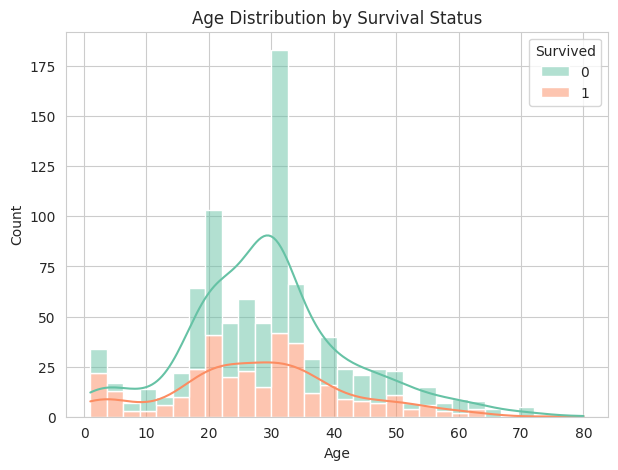

In [16]:
# Age Distribution
plt.figure(figsize=(7, 5))
sns.histplot(data=df_features, x="Age", hue="Survived", kde=True, bins=30, palette="Set2", multiple="stack")
plt.title("Age Distribution by Survival Status")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

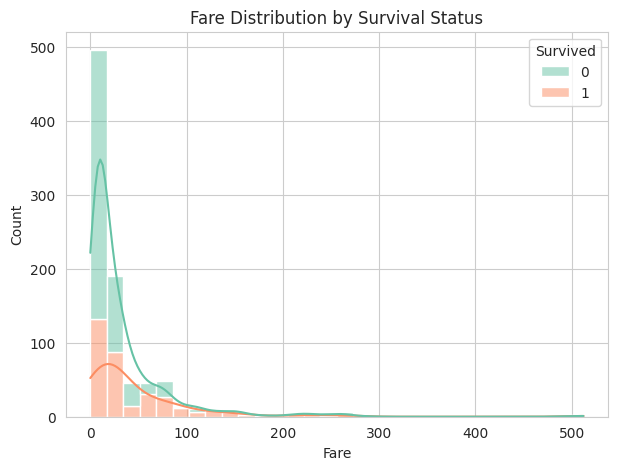

In [17]:
# 1️⃣ Fare Distribution by Survival Status
plt.figure(figsize=(7, 5))
sns.histplot(data=df_features, x="Fare", hue="Survived", kde=True, bins=30, palette="Set2", multiple="stack")
plt.title("Fare Distribution by Survival Status")
plt.show()

### Training the Model

In [18]:
# Define features and target
selected_features = [
    "Pclass", "Sex", "Age", "Fare", "Title", 
    "Family and Party Grouping", "Ticket_Prefix", "Embarked"
]

# Create a new DataFrame with selected features
df_features = df[selected_features].copy()

# Encode categorical variables (One-Hot Encoding)
df_encoded = pd.get_dummies(df_features, columns=["Sex", "Title", "Family and Party Grouping", "Ticket_Prefix", "Embarked"], drop_first=True)

# Add target variable
df_encoded["Survived"] = df["Survived"]

# Split data into training and testing sets (80% train, 20% test)
X = df_encoded.drop(columns=["Survived"])
y = df_encoded["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dataset info
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Columns: 252 entries, Pclass to Embarked_S
dtypes: bool(249), float64(2), int64(1)
memory usage: 195.4 KB
None


In [19]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.8436

Confusion Matrix:
[[92 13]
 [15 59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       105
           1       0.82      0.80      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



In [21]:
# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train model with best parameters
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy (Tuned): {accuracy_rf:.4f}")

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix (RF):")
print(conf_matrix_rf)

class_report_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report (RF):")
print(class_report_rf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Accuracy (Tuned): 0.8156

Confusion Matrix (RF):
[[90 15]
 [18 56]]

Classification Report (RF):
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



In [22]:
# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate performance
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("\nConfusion Matrix (GB):")
print(conf_matrix_gb)

class_report_gb = classification_report(y_test, y_pred_gb)
print("\nClassification Report (GB):")
print(class_report_gb)

Gradient Boosting Accuracy: 0.8659

Confusion Matrix (GB):
[[92 13]
 [11 63]]

Classification Report (GB):
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       105
           1       0.83      0.85      0.84        74

    accuracy                           0.87       179
   macro avg       0.86      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179



In [23]:
# Define parameter grid
param_grid_gb = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [5, 7, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV
grid_search_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train, y_train)

# Best parameters
print("Best Parameters (GB):", grid_search_gb.best_params_)

# Train model with best parameters
best_gb_model = GradientBoostingClassifier(**grid_search_gb.best_params_, random_state=42)
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb_tuned = best_gb_model.predict(X_test)

# Evaluate performance
accuracy_gb_tuned = accuracy_score(y_test, y_pred_gb_tuned)
print(f"Tuned Gradient Boosting Accuracy: {accuracy_gb_tuned:.4f}")

conf_matrix_gb_tuned = confusion_matrix(y_test, y_pred_gb_tuned)
print("\nConfusion Matrix (Tuned GB):")
print(conf_matrix_gb_tuned)

class_report_gb_tuned = classification_report(y_test, y_pred_gb_tuned)
print("\nClassification Report (Tuned GB):")
print(class_report_gb_tuned)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters (GB): {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Tuned Gradient Boosting Accuracy: 0.8659

Confusion Matrix (Tuned GB):
[[93 12]
 [12 62]]

Classification Report (Tuned GB):
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       105
           1       0.84      0.84      0.84        74

    accuracy                           0.87       179
   macro avg       0.86      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179

